In [1]:
import pandas as pd
from scipy.stats import levene
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from keras.layers import Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import regularizers

In [2]:
DADOS_ENEM_2023 = pd.read_csv('C:/Users/helio/OneDrive/Documents/UNB/ARTIGOS_UNB/ENEM_2023/microdados_enem_2023/DADOS/MICRODADOS_ENEM_2023.csv', sep=";", encoding='ISO-8859-1')

In [3]:
PARTIC_ENEM_2023_DF = DADOS_ENEM_2023[
    (DADOS_ENEM_2023["TP_PRESENCA_CN"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_CH"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_LC"] == 1) & 
    (DADOS_ENEM_2023["TP_PRESENCA_MT"] == 1) & 
    (DADOS_ENEM_2023["SG_UF_ESC"] == "GO") &
    (DADOS_ENEM_2023["NU_NOTA_CN"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_CH"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_MT"] > 1) & 
    (DADOS_ENEM_2023["NU_NOTA_LC"] > 1) &
    (DADOS_ENEM_2023["TP_ENSINO"] == 1) 
]

In [4]:
REG_ENEM_2023_DF = PARTIC_ENEM_2023_DF[[ 'TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL',
                                        'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA','TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 
                                        'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001','Q002','Q003','Q004','Q005','Q006','Q007', 'Q008','Q009',
                                        'Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025']]

categorical_columns = ['TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL', 'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA', 
                       'TP_LOCALIZACAO_ESC', 'Q001','Q002','Q003','Q004', 'Q006','Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019', 'Q020','Q021','Q022','Q023','Q024','Q025']

# No âmbito do DF, as variáveis 'TP_ANO_CONCLUIU', 'TP_ST_CONCLUSAO' apresentaram como valores as contanstes 0 e 2. Assim, não participarão do modelo. A vari[avel 
#CO_MUNICIPIO_ESC não foi considerada nesta avaliação inicialmente. 
#

In [5]:
# Teste de Levene e ANOVA
# Calcular média das notas e status
REG_ENEM_2023_DF['MEDIA_RESULTADO'] = (
    (REG_ENEM_2023_DF['NU_NOTA_CN'] + 
     REG_ENEM_2023_DF['NU_NOTA_CH'] + 
     REG_ENEM_2023_DF['NU_NOTA_LC'] + 
     REG_ENEM_2023_DF['NU_NOTA_MT'] + 
     REG_ENEM_2023_DF['NU_NOTA_REDACAO']) / 5
)

C:\Users\helio\AppData\Local\Temp\ipykernel_8140\2196312138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REG_ENEM_2023_DF['MEDIA_RESULTADO'] = (


In [6]:
import pandas as pd
import pingouin as pg

AMOSTRA_ENEM_DF = REG_ENEM_2023_DF.sample(n = 100)

# Dividindo a amostra com estratificação
#AMOSTRA_ENEM_DF, _ = train_test_split(PARTIC_ENEM_2023_DF, test_size=0.005, stratify=PARTIC_ENEM_2023_DF[['TP_SEXO']])
levene_SX = pg.homoscedasticity(AMOSTRA_ENEM_DF, dv="MEDIA_RESULTADO", group="TP_SEXO", method='levene', alpha=0.05)
levene_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_ESCOLA", method='levene', alpha=0.05)
levene_TP_NAC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_NACIONALIDADE", method='levene', alpha=0.05)
levene_TP_COR = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_COR_RACA", method='levene', alpha=0.05)
levene_TP_ESTCIV = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_ESTADO_CIVIL", method='levene', alpha=0.05)
levene_TP_DEP_ADM = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_DEPENDENCIA_ADM_ESC", method='levene', alpha=0.05)
levene_FX_ETAR = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_FAIXA_ETARIA", method='levene', alpha=0.05)
levene_LOC_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="TP_LOCALIZACAO_ESC", method='levene', alpha=0.05)
#levene_MUN_ESC = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="CO_MUNICIPIO_ESC", method='levene', alpha=0.05)
levene_Q001 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q001", method='levene', alpha=0.05)
levene_Q002 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q002", method='levene', alpha=0.05)
levene_Q003 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q003", method='levene', alpha=0.05)
levene_Q004 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q004", method='levene', alpha=0.05)
levene_Q005 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q005", method='levene', alpha=0.05)
levene_Q006 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q006", method='levene', alpha=0.05)
levene_Q007 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q007", method='levene', alpha=0.05)
levene_Q008 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q008", method='levene', alpha=0.05)
levene_Q009 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q009", method='levene', alpha=0.05)
levene_Q010 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q010", method='levene', alpha=0.05)
levene_Q011 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q011", method='levene', alpha=0.05)
levene_Q012 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q012", method='levene', alpha=0.05)
levene_Q013 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q013", method='levene', alpha=0.05)
levene_Q014 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q014", method='levene', alpha=0.05)
levene_Q015 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q015", method='levene', alpha=0.05)
levene_Q016 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q016", method='levene', alpha=0.05)
levene_Q017 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q017", method='levene', alpha=0.05)
levene_Q018 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q018", method='levene', alpha=0.05)
levene_Q019 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q019", method='levene', alpha=0.05)
levene_Q020 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q020", method='levene', alpha=0.05)
levene_Q021 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q021", method='levene', alpha=0.05)
levene_Q022 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q022", method='levene', alpha=0.05)
levene_Q023 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q023", method='levene', alpha=0.05)
levene_Q024 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q024", method='levene', alpha=0.05)
levene_Q025 = pg.homoscedasticity(REG_ENEM_2023_DF, dv="MEDIA_RESULTADO", group="Q025", method='levene', alpha=0.05)

In [7]:
# Criar lista de resultados
resultados = [
    ('TP_SEXO', levene_SX['W'].values[0], levene_SX['pval'].values[0]),
    ('TP_ESCOLA', levene_ESC['W'].values[0], levene_ESC['pval'].values[0]),
    ('TP_NACIONALIDADE', levene_TP_NAC['W'].values[0], levene_TP_NAC['pval'].values[0]),
    ('TP_COR_RACA', levene_TP_COR['W'].values[0], levene_TP_COR['pval'].values[0]),
    ('TP_ESTADO_CIVIL', levene_TP_ESTCIV['W'].values[0], levene_TP_ESTCIV['pval'].values[0]),
    ('TP_DEPENDENCIA_ADM_ESC', levene_TP_DEP_ADM['W'].values[0], levene_TP_DEP_ADM['pval'].values[0]),
    ('TP_FAIXA_ETARIA', levene_FX_ETAR['W'].values[0], levene_FX_ETAR['pval'].values[0]),
    ('TP_LOCALIZACAO_ESC', levene_LOC_ESC['W'].values[0], levene_LOC_ESC['pval'].values[0]),
#    ('CO_MUNICIPIO_ESC', levene_MUN_ESC['W'].values[0], levene_MUN_ESC['pval'].values[0]),
    ('Q001', levene_Q001['W'].values[0], levene_Q001['pval'].values[0]),
    ('Q002', levene_Q002['W'].values[0], levene_Q002['pval'].values[0]),
    ('Q003', levene_Q003['W'].values[0], levene_Q003['pval'].values[0]),
    ('Q004', levene_Q004['W'].values[0], levene_Q004['pval'].values[0]),
    ('Q005', levene_Q005['W'].values[0], levene_Q005['pval'].values[0]),
    ('Q006', levene_Q006['W'].values[0], levene_Q006['pval'].values[0]),
    ('Q007', levene_Q007['W'].values[0], levene_Q007['pval'].values[0]),
    ('Q008', levene_Q008['W'].values[0], levene_Q008['pval'].values[0]),
    ('Q009', levene_Q009['W'].values[0], levene_Q009['pval'].values[0]),
    ('Q010', levene_Q010['W'].values[0], levene_Q010['pval'].values[0]),
    ('Q011', levene_Q011['W'].values[0], levene_Q011['pval'].values[0]),
    ('Q012', levene_Q012['W'].values[0], levene_Q012['pval'].values[0]),
    ('Q013', levene_Q013['W'].values[0], levene_Q013['pval'].values[0]),
    ('Q014', levene_Q014['W'].values[0], levene_Q014['pval'].values[0]),
    ('Q015', levene_Q015['W'].values[0], levene_Q015['pval'].values[0]),
    ('Q016', levene_Q016['W'].values[0], levene_Q016['pval'].values[0]),
    ('Q017', levene_Q017['W'].values[0], levene_Q017['pval'].values[0]),
    ('Q018', levene_Q018['W'].values[0], levene_Q018['pval'].values[0]),
    ('Q019', levene_Q019['W'].values[0], levene_Q019['pval'].values[0]),
    ('Q020', levene_Q020['W'].values[0], levene_Q020['pval'].values[0]),
    ('Q021', levene_Q021['W'].values[0], levene_Q021['pval'].values[0]),
    ('Q022', levene_Q022['W'].values[0], levene_Q022['pval'].values[0]),
    ('Q023', levene_Q023['W'].values[0], levene_Q023['pval'].values[0]),
    ('Q024', levene_Q024['W'].values[0], levene_Q024['pval'].values[0]),
    ('Q025', levene_Q025['W'].values[0], levene_Q025['pval'].values[0])
]

# Criar DataFrame
df_resultados_lev = pd.DataFrame(resultados, columns=['Grupo', 'W', 'p-valor'])
df_resultados_lev['p-value'] = np.round(df_resultados_lev['p-valor'], 2)
df_resultados_lev['Teste'] = np.where(df_resultados_lev['p-value'] > 0.05, "ANOVA", "ANOVA_WELCH")
df_resultados_lev.head(60)

,Grupo,W,p-valor,p-value,Teste
0,TP_SEXO,0.653966,4.206573e-01,0.42,ANOVA
1,TP_ESCOLA,47.382700,5.966771e-12,0.00,ANOVA_WELCH
2,TP_NACIONALIDADE,11.667701,1.818868e-09,0.00,ANOVA_WELCH
3,TP_COR_RACA,14.530050,3.006779e-14,0.00,ANOVA_WELCH
4,TP_ESTADO_CIVIL,3.441087,8.096963e-03,0.01,ANOVA_WELCH
5,TP_DEPENDENCIA_ADM_ESC,19.257498,1.810899e-12,0.00,ANOVA_WELCH
6,TP_FAIXA_ETARIA,2.430873,1.133292e-03,0.00,ANOVA_WELCH
7,TP_LOCALIZACAO_ESC,0.546650,4.596962e-01,0.46,ANOVA
8,Q001,4.337079,8.206012e-05,0.00,ANOVA_WELCH
9,Q002,11.970429,2.451108e-15,0.00,ANOVA_WELCH


In [8]:
#AMOSTRA_ENEM_DF = REG_ENEM_2023_DF
WA_SX = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_SEXO', data=AMOSTRA_ENEM_DF)
WA_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_ESCOLA', data=AMOSTRA_ENEM_DF)
WA_TP_NAC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_NACIONALIDADE', data=AMOSTRA_ENEM_DF)
WA_TP_COR = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_COR_RACA', data=AMOSTRA_ENEM_DF)
WA_TP_ESTCIV = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_ESTADO_CIVIL', data=AMOSTRA_ENEM_DF)
WA_TP_DEP_ADM = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_DEPENDENCIA_ADM_ESC', data=AMOSTRA_ENEM_DF)
WA_FX_ETAR = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_FAIXA_ETARIA', data=AMOSTRA_ENEM_DF)
WA_LOC_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='TP_LOCALIZACAO_ESC', data=AMOSTRA_ENEM_DF)
#WA_MUN_ESC = pg.welch_anova(dv="MEDIA_RESULTADO", between='CO_MUNICIPIO_ESC', data=AMOSTRA_ENEM_DF)
WA_Q001 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q001', data=AMOSTRA_ENEM_DF)
WA_Q002 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q002', data=AMOSTRA_ENEM_DF)
WA_Q003 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q003', data=AMOSTRA_ENEM_DF)
WA_Q004 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q004', data=AMOSTRA_ENEM_DF)
WA_Q005 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q005', data=AMOSTRA_ENEM_DF)
WA_Q006 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q006', data=AMOSTRA_ENEM_DF)
WA_Q007 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q007', data=AMOSTRA_ENEM_DF)
WA_Q008 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q008', data=AMOSTRA_ENEM_DF)
WA_Q009 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q009', data=AMOSTRA_ENEM_DF)
WA_Q010 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q010', data=AMOSTRA_ENEM_DF)
WA_Q011 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q011', data=AMOSTRA_ENEM_DF)
WA_Q012 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q012', data=AMOSTRA_ENEM_DF)
WA_Q013 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q013', data=AMOSTRA_ENEM_DF)
WA_Q014 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q014', data=AMOSTRA_ENEM_DF)
WA_Q015 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q015', data=AMOSTRA_ENEM_DF)
WA_Q016 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q016', data=AMOSTRA_ENEM_DF)
WA_Q017 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q017', data=AMOSTRA_ENEM_DF)
WA_Q018 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q018', data=AMOSTRA_ENEM_DF)
WA_Q019 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q019', data=AMOSTRA_ENEM_DF)
WA_Q020 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q020', data=AMOSTRA_ENEM_DF)
WA_Q021 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q021', data=AMOSTRA_ENEM_DF)
WA_Q022 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q022', data=AMOSTRA_ENEM_DF)
WA_Q023 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q023', data=AMOSTRA_ENEM_DF)
WA_Q024 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q024', data=AMOSTRA_ENEM_DF)
WA_Q025 = pg.welch_anova(dv="MEDIA_RESULTADO", between='Q025', data=AMOSTRA_ENEM_DF)

C:\ProgramData\anaconda3\Lib\site-packages\pingouin\parametric.py:1360: RuntimeWarning: divide by zero encountered in scalar divide
  ddof2 = 1 / lamb


In [9]:
# Criar lista de resultados
resultados = [
    ('TP_SEXO', WA_SX['F'].values[0], WA_SX['p-unc'].values[0]),
    ('TP_ESCOLA', WA_ESC['F'].values[0], WA_ESC['p-unc'].values[0]),
    ('TP_NACIONALIDADE', WA_TP_NAC['F'].values[0], WA_TP_NAC['p-unc'].values[0]),
    ('TP_COR_RACA', WA_TP_COR['F'].values[0], WA_TP_COR['p-unc'].values[0]),
    ('TP_ESTADO_CIVIL', WA_TP_ESTCIV['F'].values[0], WA_TP_ESTCIV['p-unc'].values[0]),
    ('TP_DEPENDENCIA_ADM_ESC', WA_TP_DEP_ADM['F'].values[0], WA_TP_DEP_ADM['p-unc'].values[0]),
    ('TP_FAIXA_ETARIA', WA_FX_ETAR['F'].values[0], WA_FX_ETAR['p-unc'].values[0]),
    ('TP_LOCALIZACAO_ESC', WA_LOC_ESC['F'].values[0], WA_LOC_ESC['p-unc'].values[0]),
#    ('CO_MUNICIPIO_ESC', WA_MUN_ESC['F'].values[0], WA_MUN_ESC['p-unc'].values[0]),
    ('Q001', WA_Q001['F'].values[0], WA_Q001['p-unc'].values[0]),
    ('Q002', WA_Q002['F'].values[0], WA_Q002['p-unc'].values[0]),
    ('Q003', WA_Q003['F'].values[0], WA_Q003['p-unc'].values[0]),
    ('Q004', WA_Q004['F'].values[0], WA_Q004['p-unc'].values[0]),
    ('Q005', WA_Q005['F'].values[0], WA_Q005['p-unc'].values[0]),
    ('Q006', WA_Q006['F'].values[0], WA_Q006['p-unc'].values[0]),
    ('Q007', WA_Q007['F'].values[0], WA_Q007['p-unc'].values[0]),
    ('Q008', WA_Q008['F'].values[0], WA_Q008['p-unc'].values[0]),
    ('Q009', WA_Q009['F'].values[0], WA_Q009['p-unc'].values[0]),
    ('Q010', WA_Q010['F'].values[0], WA_Q010['p-unc'].values[0]),
    ('Q011', WA_Q011['F'].values[0], WA_Q011['p-unc'].values[0]),
    ('Q012', WA_Q012['F'].values[0], WA_Q012['p-unc'].values[0]),
    ('Q013', WA_Q013['F'].values[0], WA_Q013['p-unc'].values[0]),
    ('Q014', WA_Q014['F'].values[0], WA_Q014['p-unc'].values[0]),
    ('Q015', WA_Q015['F'].values[0], WA_Q015['p-unc'].values[0]),
    ('Q016', WA_Q016['F'].values[0], WA_Q016['p-unc'].values[0]),
    ('Q017', WA_Q017['F'].values[0], WA_Q017['p-unc'].values[0]),
    ('Q018', WA_Q018['F'].values[0], WA_Q018['p-unc'].values[0]),
    ('Q019', WA_Q019['F'].values[0], WA_Q019['p-unc'].values[0]),
    ('Q020', WA_Q020['F'].values[0], WA_Q020['p-unc'].values[0]),
    ('Q021', WA_Q021['F'].values[0], WA_Q021['p-unc'].values[0]),
    ('Q022', WA_Q022['F'].values[0], WA_Q022['p-unc'].values[0]),
    ('Q023', WA_Q023['F'].values[0], WA_Q023['p-unc'].values[0]),
    ('Q024', WA_Q024['F'].values[0], WA_Q024['p-unc'].values[0]),
    ('Q025', WA_Q025['F'].values[0], WA_Q025['p-unc'].values[0])
]

# Criar DataFrame
df_resultados_WA = pd.DataFrame(resultados, columns=['Grupo', 'F', 'p-unc'])
df_resultados_WA['Pvalor'] = np.round(df_resultados_WA['p-unc'],2)
df_resultados_WA['AVALIACAO'] = np.where(df_resultados_WA['Pvalor'] > 0.05, "Médias iguais entre os grupos", "Médias diferentes")

grupos_diferentes = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias diferentes']['Grupo']
grupos_iguais = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias iguais entre os grupos']['Grupo']
categorical_columns = grupos_diferentes
drop_columns = grupos_iguais
df_resultados_WA

,Grupo,F,p-unc,Pvalor,AVALIACAO
0,TP_SEXO,0.014446,0.904607,0.90,Médias iguais entre os grupos
1,TP_ESCOLA,20.037674,0.000098,0.00,Médias diferentes
2,TP_NACIONALIDADE,0.000000,1.000000,1.00,Médias iguais entre os grupos
3,TP_COR_RACA,1.766896,0.165713,0.17,Médias iguais entre os grupos
4,TP_ESTADO_CIVIL,0.006666,0.936648,0.94,Médias iguais entre os grupos
5,TP_DEPENDENCIA_ADM_ESC,9.934708,0.027004,0.03,Médias diferentes
6,TP_FAIXA_ETARIA,1.217989,0.371900,0.37,Médias iguais entre os grupos
7,TP_LOCALIZACAO_ESC,14.770295,0.031095,0.03,Médias diferentes
8,Q001,4.812793,0.001841,0.00,Médias diferentes
9,Q002,4.763670,0.000794,0.00,Médias diferentes


In [10]:
print(grupos_iguais)
#REG_ENEM_2023_DF

grupos_iguais = df_resultados_WA[df_resultados_WA['AVALIACAO'] == 'Médias iguais entre os grupos']['Grupo']
categorical_columns = grupos_diferentes.tolist()
drop_columns = grupos_iguais.tolist()
REG_ENEM_2023_DF = REG_ENEM_2023_DF.drop(columns=drop_columns)
#REG_ENEM_2023_DF
#REG_ENEM_2023_DF[categorical_columns]
#REG_ENEM_2023_DF.columns

0              TP_SEXO
2     TP_NACIONALIDADE
3          TP_COR_RACA
4      TP_ESTADO_CIVIL
6      TP_FAIXA_ETARIA
12                Q005
13                Q006
14                Q007
16                Q009
17                Q010
18                Q011
19                Q012
21                Q014
23                Q016
24                Q017
27                Q020
28                Q021
29                Q022
30                Q023
31                Q024
32                Q025
Name: Grupo, dtype: object


In [11]:
REG_ENEM_2023_DF = pd.get_dummies(REG_ENEM_2023_DF, columns=categorical_columns, prefix=categorical_columns)
# Definir X e y
X_df = REG_ENEM_2023_DF.drop(columns=['MEDIA_RESULTADO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])
y_df = REG_ENEM_2023_DF['MEDIA_RESULTADO']

# Resamplear usando SMOTE
#smt = SMOTE()
#X_df, y_df = smt.fit_resample(X_df, y_df)

print(REG_ENEM_2023_DF.shape)
print(X_df.shape)

(27109, 64)
(27109, 58)


In [12]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
RANDON_SEED = 42

# Criando o nosso seletor

variaveis = int(REG_ENEM_2023_DF.shape[1]*1)

selector = SelectKBest(score_func=mutual_info_regression, k = variaveis)

selector.fit_transform(X_df,y_df)
cols = selector.get_support(indices = True)
selected_columns = X_df.iloc[:,cols].columns.tolist()
X_df = X_df[selected_columns]

scores = selector.scores_
cols = selector.get_support(indices = True)
selected_columns = X_df.iloc[:,cols].columns.tolist()

#df_scores = pd.DataFrame(scores, columns=['score_k_best'])
#df_scores.reset_index(drop=True, inplace=True)

scores_df = pd.DataFrame({'Variáveis': X_df.columns, 'Scores': scores})
scores_df['REL'] = scores_df['Scores']/np.sum(scores_df['Scores'])
scores_df.sort_values(by='Scores', ascending=False).head(65)
#df_scores.plot()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=64 is greater than n_features=58. All the features will be returned.
  warnings.warn(


,Variáveis,Scores,REL
3,TP_DEPENDENCIA_ADM_ESC_2.0,0.136905,0.106648
5,TP_DEPENDENCIA_ADM_ESC_4.0,0.131615,0.102527
1,TP_ESCOLA_3,0.127607,0.099405
0,TP_ESCOLA_2,0.127581,0.099385
37,Q008_B,0.051761,0.040322
51,Q018_A,0.046035,0.035861
52,Q018_B,0.045975,0.035814
28,Q003_E,0.040412,0.031481
40,Q008_E,0.039263,0.030585
22,Q002_G,0.034570,0.026930


In [13]:
# Fazendo o fit com os dados
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.20, random_state = 42)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

print(X_train.shape)
print(variaveis)

(21687, 58)
64


In [14]:
modelo_2 = Sequential()
modelo_2.add(Dense(int(X_train.shape[1]*0.75), input_dim = X_train.shape[1], activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-10, l2=1e-10),
          bias_regularizer=regularizers.L2(1e-10), activity_regularizer=regularizers.L2(1e-10), 
                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDON_SEED)))
#modelo_2.add(Dropout(0.05))
#modelo_2.add(Dense(int(variaveis*1.2), activation = 'relu'))
#modelo_2.add(Dropout(0.1))
modelo_2.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

modelo_2.compile(loss='mse',optimizer=opt, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

resultado_modelo_2 = modelo_2.fit(X_train_scaled, y_train, epochs=700, batch_size = 32, validation_split=0.15, callbacks=[early_stopping])

modelo_2.evaluate(X_test_scaled, y_test)

predictions_teste = modelo_2.predict(X_test_scaled)
#previsao = pd.DataFrame(predictions_teste)
#rev_trans_test = sc.inverse_transform(X_test_scaled)
#rev_trans_test = pd.DataFrame(rev_trans_test)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 295910.0312 - mae: 535.6170 - val_loss: 189961.8281 - val_mae: 424.3708
Epoch 2/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 147147.7500 - mae: 359.9150 - val_loss: 57266.3203 - val_mae: 198.3746
Epoch 3/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49891.1094 - mae: 181.1846 - val_loss: 34422.4883 - val_mae: 145.9172
Epoch 4/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32924.1445 - mae: 140.9753 - val_loss: 27466.8145 - val_mae: 127.5732
Epoch 5/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26855.9707 - mae: 124.8494 - val_loss: 22273.4629 - val_mae: 113.6337
Epoch 6/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21676.1465 - mae: 111.4163 - val_loss: 17546.1035 - val_mae: 100.8349
Epoch 7/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16978.2441 - mae: 98.7653 - val_loss: 13614.8643 - val_mae: 89.1101
Epoch 8/700
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13129.4141 - mae: 87.

In [15]:
acuracia_modelo_2 = modelo_2.evaluate(X_test_scaled, y_test, verbose=2)
print("Testes Scores modelo_2,",acuracia_modelo_2[0])
print("Testes Accuracy modelo_2,",acuracia_modelo_2[1])

170/170 - 0s - 777us/step - loss: 6292.3291 - mae: 63.3806
Testes Scores modelo_2, 6292.3291015625
Testes Accuracy modelo_2, 63.38057327270508


array([[<Axes: title={'center': 'y_previsto'}>]], dtype=object)

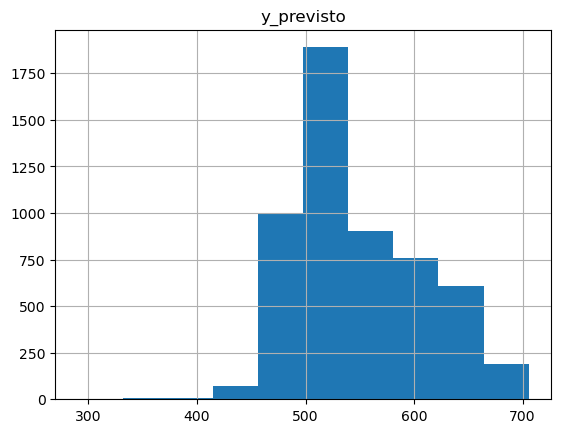

In [16]:
predictions_teste = pd.DataFrame(predictions_teste.flatten(), columns=['y_previsto'])
predictions_teste.hist()
#y_test.hist()

In [17]:
print("A média Máxima da media projetada é de: ", predictions_teste.max())
print("A média Mínima da media projetada é de: ", predictions_teste.min())
print("A média da média da media projetada é de: ", predictions_teste.mean())
print("A médiana da media projetada é de: ", predictions_teste.median())
print("A média Máxima do y_test real é de: ", y_test.max())
print("A média Mínima do y_test real é de: ", y_test.min())
print("A média da média do y_test real é de: ", y_test.mean())
print("A médiana da média do y_test real é de: ", y_test.median())

A média Máxima da media projetada é de:  y_previsto    705.573303
dtype: float32
A média Mínima da media projetada é de:  y_previsto    290.145416
dtype: float32
A média da média da media projetada é de:  y_previsto    548.022522
dtype: float32
A médiana da media projetada é de:  y_previsto    532.248352
dtype: float32
A média Máxima do y_test real é de:  813.9199999999998
A média Mínima do y_test real é de:  274.48
A média da média do y_test real é de:  551.4578126152711
A médiana da média do y_test real é de:  550.89


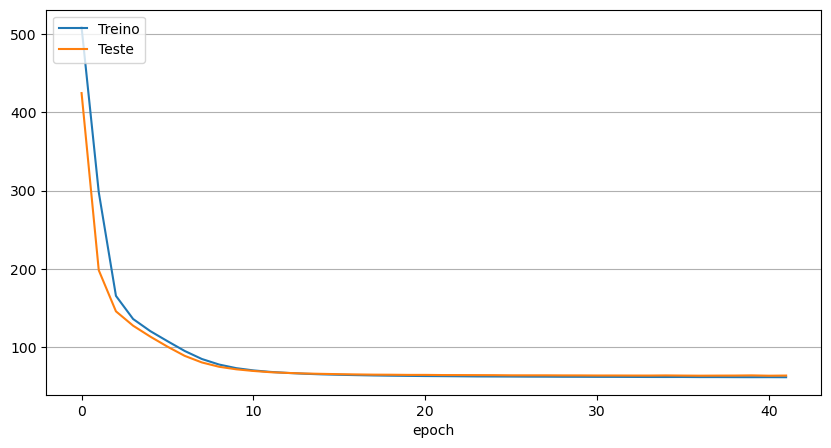

In [18]:
plt.subplots(figsize=(10,5))
plt.plot(resultado_modelo_2.history['mae'])
plt.plot(resultado_modelo_2.history['val_mae'])
plt.xlabel('epoch')
plt.grid(axis='y')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [19]:
#df_y_test = pd.DataFrame(y_test)
#previsao_modelo_2 = pd.DataFrame({'y_previsto': predictions_teste['y_previsto'], 'MEDIA_RESULTADO': df_y_test['MEDIA_RESULTADO']})

df_y_test = pd.DataFrame(y_test, columns=['MEDIA_RESULTADO'])
df_y_test.reset_index(drop=True, inplace=True)

df_predictions_teste = pd.DataFrame(predictions_teste, columns=['y_previsto'])

previsao_modelo_2 = pd.concat([predictions_teste, df_y_test],join='outer', axis=1)

previsao_modelo_2.reset_index(drop=True, inplace=True)

previsao_modelo_2['ERRO'] = np.abs(previsao_modelo_2['y_previsto'] - previsao_modelo_2['MEDIA_RESULTADO'])
previsao_modelo_2['ERRO_REL'] = np.abs(previsao_modelo_2['ERRO'] / previsao_modelo_2['MEDIA_RESULTADO'])
previsao_modelo_2.sort_values(by='ERRO_REL', ascending=True).head(15)

,y_previsto,MEDIA_RESULTADO,ERRO,ERRO_REL
1596,529.522705,529.46,0.062705,0.000118
5073,508.147247,508.22,0.072753,0.000143
5054,505.951202,505.86,0.091202,0.000180
136,572.001038,571.84,0.161038,0.000282
4335,636.078430,636.30,0.221570,0.000348
3598,432.727234,432.90,0.172766,0.000399
4461,594.173889,593.92,0.253889,0.000427
3991,525.948792,526.22,0.271208,0.000515
2412,571.118835,570.82,0.298835,0.000524
5029,601.776550,602.12,0.343450,0.000570


In [20]:
MAE_MODELO_2 = sum(previsao_modelo_2['ERRO'])/len(previsao_modelo_2['ERRO'])
MAPE_MODELO_2 = np.mean(previsao_modelo_2['ERRO_REL'])

print(MAE_MODELO_2)
print(MAPE_MODELO_2)

63.38057112088366
0.12308969621779721


In [21]:
# Definir os intervalos de erro
bins = [0, 0.1, 0.3, 0.5, 0.7, float('inf')]
labels = ['Erro entre 0% e 10%', 'Erro entre 10% e 30%', 'Erro entre 30% e 50%', 'Erro entre 50% e 70%', 'Acima de 70%']

# Categorizar os dados
previsao_modelo_2['Intervalo_ERRO_REL'] = pd.cut(previsao_modelo_2['ERRO_REL'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia = previsao_modelo_2['Intervalo_ERRO_REL'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia = pd.DataFrame({'Intervalo de Erro Relativo': labels, 'Frequência': frequencia})
tabela_frequencia['FREQ_REL'] = tabela_frequencia['Frequência']/sum(tabela_frequencia['Frequência'])
tabela_frequencia

,Intervalo de Erro Relativo,Frequência,FREQ_REL
Intervalo_ERRO_REL,,,
Erro entre 0% e 10%,Erro entre 0% e 10%,2793,0.515124
Erro entre 10% e 30%,Erro entre 10% e 30%,2284,0.421247
Erro entre 30% e 50%,Erro entre 30% e 50%,246,0.045371
Erro entre 50% e 70%,Erro entre 50% e 70%,72,0.013279
Acima de 70%,Acima de 70%,27,0.004980


In [22]:
# Definir os intervalos de erro
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['Erro entre 0 e 50 pontos', 'Erro entre 50 e 100 pontos', 'Erro entre 100 e 150 pontos', 'Erro entre 150 e 200 pontos', 'Acima de 200 pontos']

# Categorizar os dados
previsao_modelo_2['Intervalo_ERRO'] = pd.cut(previsao_modelo_2['ERRO'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia_abs = previsao_modelo_2['Intervalo_ERRO'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia_abs = pd.DataFrame({'Intervalo de Erro': labels, 'Frequência': frequencia_abs})
tabela_frequencia['FREQ_ABS'] = tabela_frequencia_abs['Frequência']/sum(tabela_frequencia['Frequência'])
tabela_frequencia_abs

,Intervalo de Erro,Frequência
Intervalo_ERRO,,
Erro entre 0 e 50 pontos,Erro entre 0 e 50 pontos,2537
Erro entre 50 e 100 pontos,Erro entre 50 e 100 pontos,1789
Erro entre 100 e 150 pontos,Erro entre 100 e 150 pontos,781
Erro entre 150 e 200 pontos,Erro entre 150 e 200 pontos,236
Acima de 200 pontos,Acima de 200 pontos,79


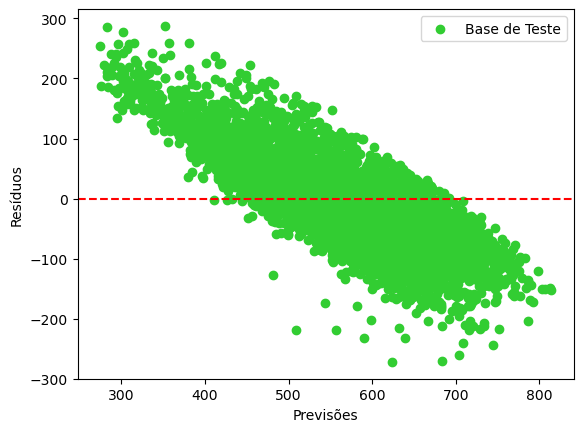

In [23]:
# Supondo que y_pred e y_test já estão definidos
plt.scatter(previsao_modelo_2['MEDIA_RESULTADO'], previsao_modelo_2['y_previsto'] - previsao_modelo_2['MEDIA_RESULTADO'], c='limegreen', label='Base de Teste')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.legend()
plt.show()

#df_predictions_teste = pd.DataFrame(predictions_teste, columns=['y_previsto'])

In [24]:
# Teste modelo fora da amostra de treino e teste

In [92]:
# Verificando o resultado
#print(AMOSTRA_TESTE_DF.head())

from sklearn.model_selection import train_test_split

# Dividindo a amostra com estratificação
AMOSTRA_TESTE_DF, _ = train_test_split(PARTIC_ENEM_2023_DF, test_size=0.90, random_state = 42)

AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF[['TP_SEXO', 'TP_ESCOLA', 'TP_NACIONALIDADE', 'TP_COR_RACA', 'TP_ESTADO_CIVIL', 'TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA',
                                     'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001',
                                     'Q002','Q003','Q004','Q005','Q006','Q007', 'Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018',
                                     'Q019','Q020','Q021','Q022','Q023','Q024','Q025']]
# Calcular média das notas e status
AMOSTRA_TESTE_DF['MEDIA_RESULTADO'] = (
    (AMOSTRA_TESTE_DF['NU_NOTA_CN'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_CH'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_LC'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_MT'] + 
     AMOSTRA_TESTE_DF['NU_NOTA_REDACAO']) / 5
)
AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF.drop(columns=drop_columns)

AMOSTRA_TESTE_DF = pd.get_dummies(AMOSTRA_TESTE_DF, columns=categorical_columns, prefix=categorical_columns)
# Definir X e y
AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF.drop(columns=['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])

colunas_faltantes_em_X_train = set(AMOSTRA_TESTE_DF.columns) - set(X_train.columns)
colunas_faltantes_em_AMOSTRA_TESTE_DF = set(X_train.columns) - set(AMOSTRA_TESTE_DF.columns)

AMOSTRA_TESTE_DF.columns

# Adicionar colunas faltantes com valores zero
for coluna in colunas_faltantes_em_AMOSTRA_TESTE_DF:
    AMOSTRA_TESTE_DF[coluna] = 0

# Verificar se as colunas estão na mesma ordem de X_train.columns
#AMOSTRA_TESTE_DF = AMOSTRA_TESTE_DF[X_train.columns]

# Verificando o resultado
print(colunas_faltantes_em_X_train)
print(colunas_faltantes_em_AMOSTRA_TESTE_DF)

{'MEDIA_RESULTADO'}
{'Q015_E'}


In [94]:
# Criar colunas faltantes com valor zerado
#AMOSTRA_TESTE_DF['Q016_E'] = False
AMOSTRA_TESTE_DF['Q015_E'] = False
#AMOSTRA_TESTE_DF['Q005_14'] = False
#AMOSTRA_TESTE_DF['Q005_19'] = False
#AMOSTRA_TESTE_DF['Q008_A'] = False
#AMOSTRA_TESTE_DF.columns

In [98]:
#AMOSTRA_TESTE_DF.columns
X_BKT = AMOSTRA_TESTE_DF
y_BKT = AMOSTRA_TESTE_DF['MEDIA_RESULTADO']

X_BKT = AMOSTRA_TESTE_DF[X_train.columns]

colunas_faltantes_em_X_train = set(X_BKT.columns) - set(X_train.columns)
colunas_faltantes_em_X_BKT = set(X_train.columns) - set(X_BKT.columns)

# Verificando o resultado
print(colunas_faltantes_em_X_train)
print(colunas_faltantes_em_X_BKT)

set()
set()


In [100]:
sc = StandardScaler()
X_BKT_scaled = sc.fit_transform(X_BKT)
predictions_teste_BKT = modelo_2.predict(X_BKT_scaled)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


Index(['y_previsto_BKT'], dtype='object')

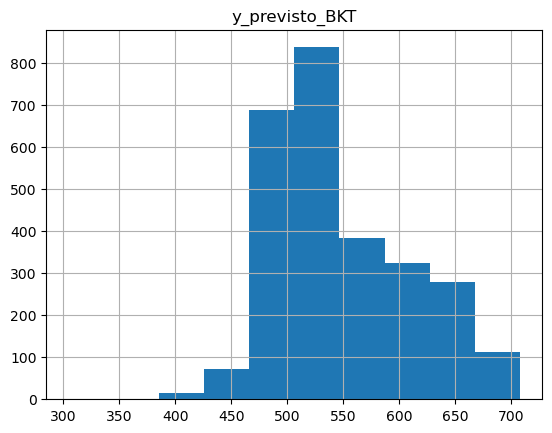

In [102]:
predictions_teste_BKT = pd.DataFrame(predictions_teste_BKT.flatten(), columns=['y_previsto_BKT'])
predictions_teste_BKT.hist()
predictions_teste_BKT.columns
#y_test.hist()

In [104]:
print("A média Máxima da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].max())
print("A média Mínima da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].min())
print("A média da média da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].mean())
print("A médiana da media projetada é de: ", predictions_teste_BKT['y_previsto_BKT'].median())
print("A média Máxima do y_test real é de: ", y_BKT.max())
print("A média Mínima do y_test real é de: ", y_BKT.min())
print("A média da média do y_test real é de: ", y_BKT.mean())
print("A médiana da média do y_test real é de: ", y_BKT.median())

A média Máxima da media projetada é de:  708.0540161132812
A média Mínima da media projetada é de:  304.85650634765625
A média da média da media projetada é de:  548.4854
A médiana da media projetada é de:  532.5880737304688
A média Máxima do y_test real é de:  821.9200000000001
A média Mínima do y_test real é de:  262.26
A média da média do y_test real é de:  548.2985387453874
A médiana da média do y_test real é de:  549.08


In [106]:
#df_y_test = pd.DataFrame(y_test)
#previsao_modelo_2 = pd.DataFrame({'y_previsto': predictions_teste['y_previsto'], 'MEDIA_RESULTADO': df_y_test['MEDIA_RESULTADO']})

df_y_BKT = pd.DataFrame(y_BKT, columns=['MEDIA_RESULTADO'])
df_y_BKT.reset_index(drop=True, inplace=True)

df_predictions_teste = pd.DataFrame(predictions_teste_BKT, columns=['y_previsto_BKT'])

previsao_modelo_2_BKT = pd.concat([predictions_teste_BKT, df_y_BKT],join='outer', axis=1)

previsao_modelo_2_BKT.reset_index(drop=True, inplace=True)

previsao_modelo_2_BKT['ERRO'] = np.abs(previsao_modelo_2_BKT['y_previsto_BKT'] - previsao_modelo_2_BKT['MEDIA_RESULTADO'])
previsao_modelo_2_BKT['ERRO_REL'] = np.abs(previsao_modelo_2_BKT['ERRO'] / previsao_modelo_2_BKT['MEDIA_RESULTADO'])
previsao_modelo_2_BKT.sort_values(by='ERRO_REL', ascending=True).head(15)

,y_previsto_BKT,MEDIA_RESULTADO,ERRO,ERRO_REL
2641,484.407318,484.44,0.032682,0.000067
741,549.620483,549.66,0.039517,0.000072
840,673.958862,673.86,0.098862,0.000147
1190,490.819183,490.90,0.080817,0.000165
1601,490.979034,490.80,0.179034,0.000365
1678,581.088074,580.86,0.228074,0.000393
609,537.159912,537.42,0.260088,0.000484
1817,499.238953,499.50,0.261047,0.000523
420,509.648773,509.34,0.308773,0.000606
1126,600.174805,600.54,0.365195,0.000608


In [108]:
MAE_MODELO_2_BKT = sum(previsao_modelo_2_BKT['ERRO'])/len(previsao_modelo_2_BKT['ERRO'])
MAPE_MODELO_2_BKT = np.mean(previsao_modelo_2_BKT['ERRO_REL'])

print(MAE_MODELO_2_BKT)
print(MAPE_MODELO_2_BKT)

64.57709119823491
0.1262855001792312


In [110]:
# Definir os intervalos de erro
bins = [0, 0.1, 0.3, 0.5, 0.7, float('inf')]
labels = ['Erro entre 0% e 10%', 'Erro entre 10% e 30%', 'Erro entre 30% e 50%', 'Erro entre 50% e 70%', 'Acima de 70%']

# Categorizar os dados
previsao_modelo_2_BKT['Intervalo_ERRO_REL'] = pd.cut(previsao_modelo_2_BKT['ERRO_REL'], bins=bins, labels=labels)

# Construir a tabela de distribuição de frequência
frequencia_BKT = previsao_modelo_2_BKT['Intervalo_ERRO_REL'].value_counts().sort_index()

# Exibir a tabela de distribuição de frequência
tabela_frequencia_BKT = pd.DataFrame({'Intervalo de Erro Relativo': labels, 'Frequência_BKT': frequencia_BKT})
tabela_frequencia_BKT['FREQ_REL'] = tabela_frequencia_BKT['Frequência_BKT']/sum(tabela_frequencia_BKT['Frequência_BKT'])
tabela_frequencia_BKT

,Intervalo de Erro Relativo,Frequência_BKT,FREQ_REL
Intervalo_ERRO_REL,,,
Erro entre 0% e 10%,Erro entre 0% e 10%,1365,0.503690
Erro entre 10% e 30%,Erro entre 10% e 30%,1171,0.432103
Erro entre 30% e 50%,Erro entre 30% e 50%,117,0.043173
Erro entre 50% e 70%,Erro entre 50% e 70%,43,0.015867
Acima de 70%,Acima de 70%,14,0.005166


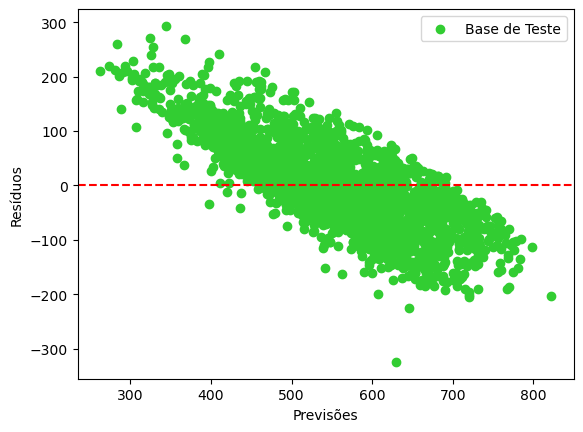

In [112]:
# Supondo que y_pred e y_test já estão definidos
plt.scatter(previsao_modelo_2_BKT['MEDIA_RESULTADO'], previsao_modelo_2_BKT['y_previsto_BKT'] - previsao_modelo_2_BKT['MEDIA_RESULTADO'], 
            c='limegreen', label='Base de Teste')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.legend()
plt.show()